# Model fitting of Tambuscio _et. al_

## Imports

The Python module needed to run this notebook. Just run this cell once.

In [144]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['text.usetex'] = False

import matplotlib.pyplot as plt

import numpy
import pandas
import os
import json

from contextlib import closing

## Reading the data

_**IMPORTANT**: Adjust the paths below to those of your own files._

Data are stored in two separate files. An HDF5 [store file](https://pandas.pydata.org/pandas-docs/version/0.22/io.html#hdf5-pytables) that includes a dataframe for each story, and a dictionary with the URLs of 
both `fake` and `fact` articles. 
Note that to be able to read the HDF file you will need PyTables to be installed alongside with Pandas.

In [5]:
hdf_store_path = './data.hdf'
urls_json_path = './data.json'

Evaluate this cell to read the data. `data` is a dictionary mapping `story_id` to each data frame. `urls` is a dictionary of lists with two entries: one called `"fact"` and one called `"fake"`. Each list includes the full URLs of the articles of each story. For each ID the corresponding columns in the data frame are named with the domain of the website and a progressive number in case of multiple stories from the same website (e.g. `infowars.com`, `infowars.com1`, etc.).

In [6]:
store = pandas.HDFStore(hdf_store_path)
with closing(store):
    data = dict((int(k.split('_')[1]), store[k]) for k in store)

with closing(open(urls_json_path)) as f:
    urls = json.load(f)

Each has a number of columns equal to the articles in the story. Columns are grouped by type (`fake` or `fact`). For example, let's get the first story in the data set:

In [7]:
k0 = sorted(data.keys())[0]
print(k0)

3


In [8]:
df = data[k0]
df.head()

,fact,fake
,politifact.com,breitbart.com
timestamp,,
2017-03-03 08:00:00,0.0,226.0
2017-03-03 09:00:00,0.0,229.0
2017-03-03 10:00:00,0.0,231.0
2017-03-03 11:00:00,0.0,234.0
2017-03-03 12:00:00,0.0,238.0


This frame has exactly two columns, since there is only one article per type, one from Politifact and one To know which articles are they, look into the `urls` dict. (Note that keys are strings here, due to JSON allowing only strings as keys.)

In [9]:
urls[str(k0)]

{'fact': ['politifact.com/truth-o-meter/article/2017/mar/06/did-donald-trump-invent-claim-barack-obama-tapped-/'],
 'fake': ['breitbart.com/big-government/2017/03/03/mark-levin-obama-used-police-state-tactics-undermine-trump/']}

## Plotting the data

We can aggregate all articles by group and plot the data for each story. Since all data frames will have exactly the same columns, we can simply concatenate them all together into a single frame indexed by story ID.

In [113]:
df = pandas.concat(dict((k, df.sum(axis=1, level=0)) for k, df in data.items()), names=['story_id'])

Now the data frame has a hierarchical index, with the first level being the ID of the story, and the second level the timestamp.

In [11]:
df.head()

fact   fake
story_id timestamp                       
3        2017-03-03 08:00:00   0.0  226.0
         2017-03-03 09:00:00   0.0  229.0
         2017-03-03 10:00:00   0.0  231.0
         2017-03-03 11:00:00   0.0  234.0
         2017-03-03 12:00:00   0.0  238.0

Let's create a list with the IDs of the stories

In [12]:
keys = sorted(data.keys())

### All stories together, fake vs fact

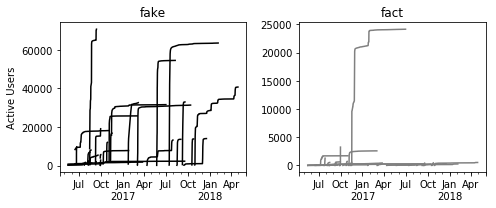

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
for k in keys:
    df.loc[k]['fake'].plot(ax=axs[0], color='k', legend=False)
    df.loc[k]['fact'].plot(ax=axs[1], color='gray', legend=False)

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[0].set_ylabel('Active Users')

axs[0].set_title("fake")
axs[1].set_title("fact")
plt.tight_layout()

### Each story individually, fake and fact

In [151]:
def plotall(df, max_nrows, max_ncols, max_figsize, **kwargs):
    """
    Additional keyword arguments are passed to the plot of method of each data frame
    """
    plots_per_page = max_nrows * max_ncols
    keys = list(df.index.get_level_values(0).unique())
    n_subplots_tot = len(keys)
    max_width, max_height = max_figsize    
    w_subplot = max_width / max_ncols
    h_subplot = max_height / max_nrows
    for i in range(0, n_subplots_tot, plots_per_page):
        j = i + plots_per_page
        keys_to_plot = keys[i:j]
        n_subplots = len(keys_to_plot)
        if n_subplots < n_subplots_tot:
            # adjust number of columns, rows and figsize based on n_subplots
            nrows = int(numpy.ceil(n_subplots / max_ncols))
            if nrows == 1:
                ncols = n_subplots
            else:
                ncols = max_ncols
            width = ncols * w_subplot
            height = nrows * h_subplot
            figsize = (width, height)
        else:
            # use maximum number of rows, colors, and figsize
            nrows = max_nrows
            ncols = max_ncols
            figsize = max_figsize
        
        subplots_kwargs = dict(nrows=nrows, ncols=ncols, figsize=(width, height))
        
        fig, axs = plt.subplots(**subplots_kwargs)

        for k, ax in zip(keys_to_plot, axs.ravel()):
            ts = df.loc[k]
            t0 = ts.index[0].date()
            ts = ts.reset_index(drop=True)
            ts.plot(ax=ax, legend=False, **kwargs)
            ax.set_xlabel('')
            ax.set_title("${}$".format(k))
            ymin, ymax = ax.get_ylim()
            ax.set_ylim(ymin, ymax + 0.25 * (ymax - ymin))
            ax.text(0.5, 0.85, "$t_0=$ {}".format(t0), transform=ax.transAxes, horizontalalignment='center')

        # put legend on first plot
        axs = numpy.atleast_2d(axs)
        axs[0, 0].legend(frameon=False, loc='best')
        
        # Add x-label on bottom row
        if ncols % 2 == 0:
            # If there is an even number of columns, then add x-label every other plot
            axs_to_xlabel = [axs[-1, jj] for jj in range(0, ncols, 2)]
        else:
            # Else add x-label to the center plot only
            axs_to_xlabel = [axs[-1, ncols // 2]]
        for ax in axs_to_xlabel:
            ax.set_xlabel('Hours since $t_0$', fontsize='x-large')
        # Add y-label on left column
        if nrows % 2 == 0:
            # Add y-label every other plot
            axs_to_ylabel = [axs[ii, 0] for ii in range(0, nrows, 2)]
        else:
            axs_to_ylabel = [axs[nrows // 2, 0]]
        for ax in axs_to_ylabel:
            ax.set_ylabel('Active Users', fontsize='x-large')
        
        # delete any unused subplot        
        for ax in axs.ravel()[n_subplots:]:
            fig.delaxes(ax)
        
        # set tight layout
        plt.tight_layout()

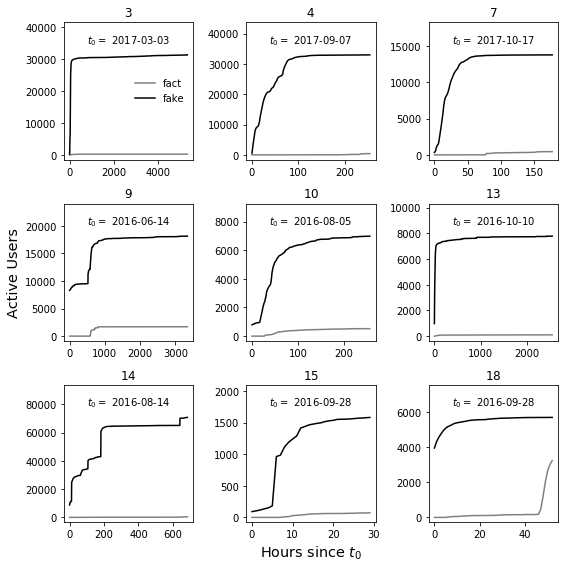

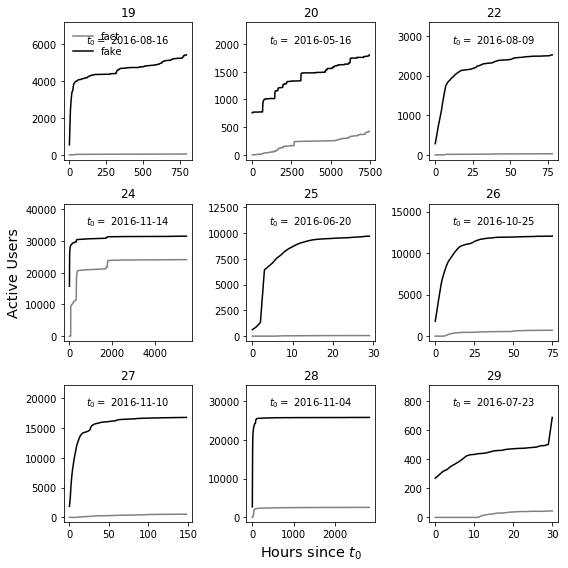

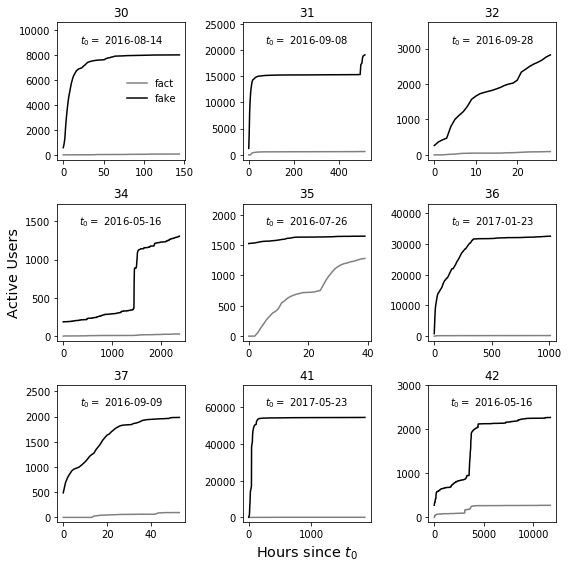

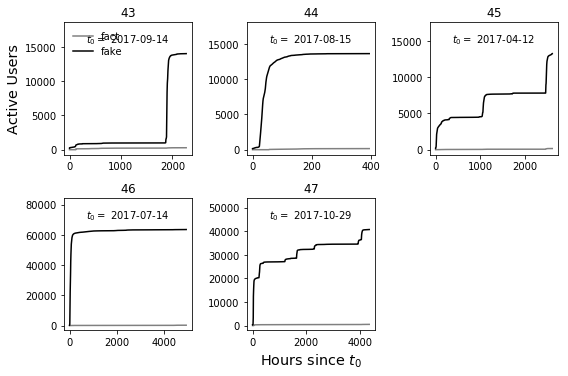

In [152]:
nrows = 3
ncols = 3
figsize = (8, 8)

plotall(df, nrows, ncols, figsize, color=['gray', 'k'])

### Plotting one story with multiple URLs, each URL separate, plus the total tweets per group of URLs

In [138]:
# TODO: 
# 1. Add legend, 
# 2. Split plot in two for fact/fake and remove log scale? 
# 3. Can integrate in plotall so that plotall takes whathever plotting task one wants?

def plotonewithurls(df, k):
    t0 = df.index[0]
    df = df.reset_index(drop=True)

    fig = plt.gcf()
    ax = plt.gca()

    df['fake'].plot(legend=False, color='k', ls='--', ax=ax)
    df['fake'].sum(axis=1).plot(legend=False, color='k', ls='-', ax=ax)

    df['fact'].plot(legend=False, color='r', ls='--', ax=ax)
    df['fact'].sum(axis=1).plot(legend=False, color='r', ls='-', ax=ax)

    ax.set_yscale('symlog')
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax * 10)
    ax.text(0.5, 0.9, "$t_0=$ {}".format(t0), transform=ax.transAxes, horizontalalignment='center')

    ax.set_xlabel('Hours since $t_0$')
    ax.set_ylabel('Active Users')
    ax.set_title(str(k))
    plt.tight_layout()

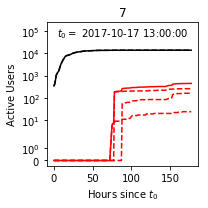

In [139]:
k = 7
plt.figure(figsize=(3, 3))
plotonewithurls(data[k], k)